<a href="https://colab.research.google.com/github/Nagalakshmi136/image-classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from datetime import datetime
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters

In [2]:
learning_rate = 0.01
epochs = 150
batch_size = 128

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset = CIFAR10("./data", train = True, transform=transform_train, download=True)
test_dataset = CIFAR10("./data", train = False, transform=transform_test, download=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:04<00:00, 38866696.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validate_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
len(train_loader.dataset)

50000

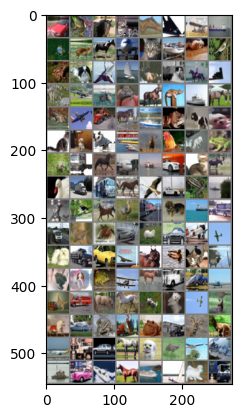

car frog horse cat horse plane plane ship frog deer horse plane cat ship dog bird frog dog plane ship deer cat horse plane deer plane deer frog horse cat ship horse frog plane truck horse ship frog dog dog cat dog dog plane deer bird dog frog frog truck horse plane ship car cat deer bird truck truck horse bird car frog ship dog cat horse bird truck dog ship truck truck bird horse ship dog car plane plane dog truck car plane horse bird cat deer frog dog frog plane horse car truck plane cat truck horse horse cat dog plane deer horse car frog truck frog truck deer deer plane truck car horse dog bird plane ship ship car ship horse ship ship dog truck


In [7]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
train_images, train_labels = next(dataiter)
# call function on our images
imshow(make_grid(train_images))

# print the class of the image
print(' '.join('%s' % classes[train_labels[j]] for j in range(batch_size)))

## ResNet 18 Implementation

In [17]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sample):
        super(ResNetBlock,self).__init__()
        self.skip_connection = nn.Sequential()
        if down_sample:
            self.conv1 = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=(2,2),
                padding=(1,1),
                bias=False
            )

            self.skip_connection = nn.Sequential(
                nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1,1),
                stride=(2,2),
                padding=(0,0),
                bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=(1,1),
                padding=(1,1),
                bias=False
            )
        self.bnorm1=nn.BatchNorm2d(out_channels)
        self.bnorm2=nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=(1,1),
                padding=(1,1),
                bias=False
            )
    def forward(self, input):
        skip_conn = self.skip_connection(input)
        input = nn.ReLU()(self.bnorm1(self.conv1(input)))
        input = nn.ReLU()(self.bnorm2(self.conv2(input)))
        input = nn.ReLU()(input+skip_conn)
        return input



In [18]:
def conv_block(in_channels, out_channels):
  return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3,3),
            stride=(1,1),
            padding=(1,1),
            bias=False,
            ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
  )

class ResNet(nn.Module):
    def __init__(self,num_classes) -> None:
        super().__init__()
        self.conv1 = conv_block(3,64)
        self.layer1 = nn.Sequential(
            ResNetBlock(64,64,True),
            ResNetBlock(64,64,False)
            )
        self.layer2 = nn.Sequential(
            ResNetBlock(64,128,True),
            ResNetBlock(128,128,False)
            )
        self.layer3 = nn.Sequential(
            ResNetBlock(128,256,True),
            ResNetBlock(256,256,False)
            )
        self.layer4 = nn.Sequential(
            ResNetBlock(256,512,True),
            ResNetBlock(512,512,False)
        )
        self.linear = nn.Linear(in_features=512,out_features=num_classes)

    def forward(self, input_data):
        output = self.conv1(input_data)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = F.avg_pool2d(output,output.size()[3])
        output = output.view(output.shape[0],-1)
        output = self.linear(F.dropout(output))
        probs = F.softmax(output,dim=1)
        return probs



## Training the Model

In [19]:
def train(train_loader, model, optimizer, criterion):
    running_loss = 0.0
    for train_images, train_labels in tqdm(train_loader):
        # images, labels = batch_data
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        optimizer.zero_grad()
        output_labels = model(train_images) # forward
        loss = criterion(output_labels,train_labels) # loss
        running_loss += loss.item()*train_images.size(0)
        loss.backward() # backward
        optimizer.step() # update weights
    epoch_loss=running_loss/len(train_loader.dataset)
    return model,optimizer,epoch_loss

In [20]:
def validate(validate_loader,model,criterion):
    running_loss = 0.0
    with torch.no_grad():
        for validate_images, validate_labels in tqdm(validate_loader):
            validate_images = validate_images.to(device)
            validate_labels = validate_labels.to(device)
            output_labels = model(validate_images)
            loss = criterion(output_labels,validate_labels)
            running_loss += loss.item()*validate_images.size(0)
    epoch_loss=running_loss/len(validate_loader.dataset)
    return model,epoch_loss


In [21]:
def get_accuracy(model,data_loader):
    correct_pred=0
    total_size = len(data_loader.dataset)
    with torch.no_grad():
        for input_images,input_labels in data_loader:

            input_images= input_images.to(device)
            input_labels = input_labels.to(device)

            predicted_labels = model(input_images)
            predicted_labels = torch.argmax(predicted_labels,dim=1).flatten()
            correct_pred += torch.eq(predicted_labels,input_labels).sum().item()
    return float(correct_pred/total_size)*100

# Plotting Graphs

In [22]:
def plot_losses(train_losses, validate_losses,epochs):
    train_losses=np.array(train_losses)
    validate_losses=np.array(validate_losses)
    _, ax = plt.subplots(figsize = (epochs,5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(validate_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()

def plot_accuracy(train_accuracy, validate_accuracy,epochs):
    train_accuracy=np.array(train_accuracy)
    validate_accuracy=np.array(validate_accuracy)
    _, ax = plt.subplots(figsize = (epochs,5))

    ax.plot(train_accuracy, color='blue', label='Training loss')
    ax.plot(validate_accuracy, color='red', label='Validation loss')
    ax.set(title="Accuracy over epochs",
            xlabel='Epoch',
            ylabel='Accuracy')
    ax.legend()

In [23]:
def training_loop(train_loader,validate_loader,model,criterion,optimizer,epochs,print_loss=False ):
    train_losses = []
    validate_losses = []
    train_accuracy = []
    validate_accuracy = []
    k=0
    for epoch in range(epochs):
        model,optimizer,train_loss=train(train_loader=train_loader,model=model,optimizer=optimizer,criterion=criterion)
        train_losses.append(train_loss)
        with torch.no_grad():
            model,validate_loss=validate(validate_loader=validate_loader,model=model,criterion=criterion)
            validate_losses.append(validate_loss)
        if print_loss and k==0 or epoch%k==0 or epoch==epochs-1:
            train_acc=get_accuracy(model,train_loader)
            valid_acc=get_accuracy(model=model,data_loader=validate_loader)
            train_accuracy.append(train_acc)
            validate_accuracy.append(valid_acc)
            print(f"{datetime.now().time().replace(microsecond=0)}----"
                  f"Epoch: {epoch}\t"
                  f"Train loss: {train_loss:.4f}\t"
                  f"Valid loss: {validate_loss:.4f}\t"
                  f"Train accuracy: {train_acc:.2f}\t"
                  f"Valid accuracy: {valid_acc:.2f}")
            k+=epochs//10
    plot_losses(train_losses=train_losses,validate_losses=validate_losses,epochs=epochs)
    plot_accuracy(train_accuracy=train_accuracy,validate_accuracy=validate_accuracy,epochs=epochs)
    return model,optimizer,(train_accuracy[-1],validate_accuracy[-1])


In [24]:
model = ResNet(10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9)

100%|██████████| 79/79 [00:02<00:00, 27.37it/s]


05:45:01----Epoch: 0	Train loss: 2.0934	Valid loss: 1.9825	Train accuracy: 45.15	Valid accuracy: 46.91


100%|██████████| 79/79 [00:03<00:00, 20.92it/s]


05:54:01----Epoch: 15	Train loss: 1.7153	Valid loss: 1.7048	Train accuracy: 74.44	Valid accuracy: 75.61


100%|██████████| 79/79 [00:02<00:00, 27.15it/s]


06:03:34----Epoch: 30	Train loss: 1.6479	Valid loss: 1.6416	Train accuracy: 82.40	Valid accuracy: 81.94


100%|██████████| 79/79 [00:02<00:00, 27.62it/s]


06:12:50----Epoch: 45	Train loss: 1.6153	Valid loss: 1.6266	Train accuracy: 84.70	Valid accuracy: 83.44


100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


06:21:56----Epoch: 60	Train loss: 1.5904	Valid loss: 1.6088	Train accuracy: 87.01	Valid accuracy: 85.03


100%|██████████| 79/79 [00:02<00:00, 27.57it/s]


06:31:12----Epoch: 75	Train loss: 1.5730	Valid loss: 1.5967	Train accuracy: 89.12	Valid accuracy: 86.24


100%|██████████| 79/79 [00:02<00:00, 27.10it/s]


06:40:24----Epoch: 90	Train loss: 1.5605	Valid loss: 1.5845	Train accuracy: 90.72	Valid accuracy: 87.66


100%|██████████| 79/79 [00:02<00:00, 28.00it/s]


06:49:32----Epoch: 105	Train loss: 1.5495	Valid loss: 1.5824	Train accuracy: 91.44	Valid accuracy: 87.73


100%|██████████| 79/79 [00:02<00:00, 28.76it/s]


06:58:43----Epoch: 120	Train loss: 1.5386	Valid loss: 1.5823	Train accuracy: 91.92	Valid accuracy: 87.79


100%|██████████| 79/79 [00:02<00:00, 28.05it/s]


07:07:46----Epoch: 135	Train loss: 1.5335	Valid loss: 1.5748	Train accuracy: 92.90	Valid accuracy: 88.46


100%|██████████| 79/79 [00:03<00:00, 25.08it/s]


07:16:17----Epoch: 149	Train loss: 1.5255	Valid loss: 1.5691	Train accuracy: 93.78	Valid accuracy: 88.95


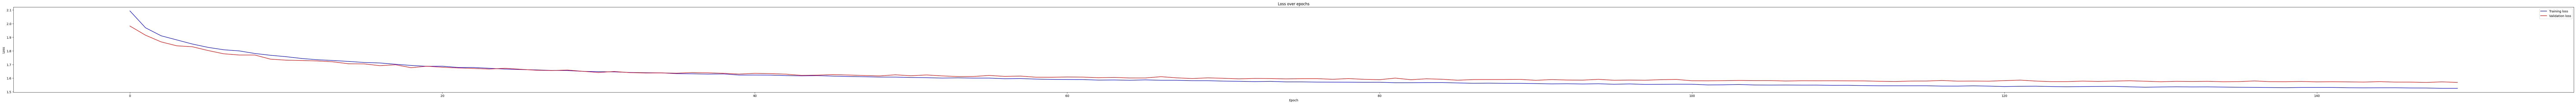

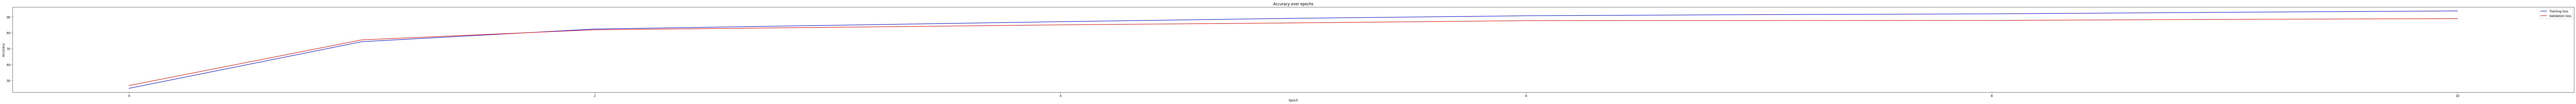

In [25]:
model, optimizer, accuracies = training_loop(train_loader=train_loader, validate_loader=validate_loader,model=model,optimizer=optimizer,criterion=criterion,epochs=epochs,print_loss=True)